In [3]:
!pip install pytorch_forecasting

In [4]:
!pip install torch torchvision

In [5]:
# imports

import copy
from pathlib import Path
import warnings
import holidays
import seaborn as sns
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') #Not a great fan of their website (I found it super-biased), but this stylesheet is the best

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import random
import gc
import tensorflow as tf
import tensorboard as tb
#tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)
torch.manual_seed(30)
torch.cuda.manual_seed(30)

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [7]:
# Load the uploaded CSV file to understand its structure
file_path = 'MK2000_with_macro_and_volatility.csv'
data = pd.read_csv(file_path)

In [8]:
# Step 1: Data Preprocessing
# Convert 'Date' to datetime and sort by date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

In [9]:
# Define target (Volatility) and features
target_col = 'Volatility'
feature_cols = [col for col in data.columns if col not in ['Date', target_col]]

In [10]:
# Scale features and target
scaler = MinMaxScaler()
data[feature_cols] = scaler.fit_transform(data[feature_cols])
data[target_col] = scaler.fit_transform(data[[target_col]])

In [11]:
# Train-test split
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

In [12]:
# Prepare dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, target_col, feature_cols):
        self.data = data
        self.seq_len = seq_len
        self.target_col = target_col
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data.iloc[idx : idx + self.seq_len][self.feature_cols].values
        y = self.data.iloc[idx + self.seq_len][self.target_col]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [13]:
# Hyperparameters
SEQ_LEN = 30  # Sequence length
BATCH_SIZE = 64

In [14]:
# Create DataLoaders
train_dataset = TimeSeriesDataset(train_data, SEQ_LEN, target_col, feature_cols)
val_dataset = TimeSeriesDataset(val_data, SEQ_LEN, target_col, feature_cols)
test_dataset = TimeSeriesDataset(test_data, SEQ_LEN, target_col, feature_cols)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
# Display dataset structure for confirmation
len(train_dataset), len(val_dataset), len(test_dataset)

(4610, 1131, 1421)

In [16]:
# Add a time_idx (an sequence of consecutive integers that goes from min to max date)

data = (data.merge((data[['Date']].drop_duplicates(ignore_index=True)
.rename_axis('time_idx')).reset_index(), on = ['Date']))

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [17]:
# Data loading
data = pd.read_csv('MK2000_with_macro_and_volatility.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date column is in datetime format

# Check uniqueness of the date column
assert len(data['Date'].drop_duplicates()) == len(data)

# No country/store/product columns, so check data integrity differently
assert data.isna().sum().sum() == 0, "Dataset contains missing values."

# Display a sample of the data
display(data.sample(4))


,row_id,Date,open,high,low,close,volume,return,Log_Return,Volatility,exc,ktb,trm,spr,days_from_start,day_of_week,day_of_month,week_of_year,month
6819,1,2023-09-03,2453.00,2517.11,2415.47,2469.70,1454698861,0.53,1.000000e-09,0.006559,1318.8,3.689,2200,64180,6820,7,3,35,9
2716,1,2012-06-09,1676.68,1692.48,1643.79,1658.33,915194455,-0.75,1.000000e-09,0.011744,1175.4,3.250,900,56100,2717,6,9,23,6
2744,1,2012-07-07,1700.33,1712.80,1664.41,1681.29,994829667,-0.88,1.000000e-09,0.009117,1137.8,3.230,1000,56100,2745,6,7,27,7
1969,1,2010-05-24,1439.33,1479.51,1422.49,1457.12,706978528,0.43,4.270939e-03,0.011777,1214.5,3.640,16100,60500,1970,1,24,21,5


In [18]:
# Check for missing values (NaNs) in the dataset
missing_values = (
    data.isna()
    .sum(axis=0)
    .rename('nans_per_column')
    .rename_axis('column')
    .reset_index()
)

# Display the missing values information
print("Number of NaNs per column:")
display(missing_values)


Number of NaNs per column:


,column,nans_per_column
0,row_id,0
1,Date,0
2,open,0
3,high,0
4,low,0
5,close,0
6,volume,0
7,return,0
8,Log_Return,0
9,Volatility,0


In [19]:
# Check for number of unique values in each column
unique_values = (
    data.nunique(axis=0)
    .rename('n_unique_per_column')
    .rename_axis('column')
    .reset_index()
)

# Display the number of unique values per column
print("Number of unique values per column:")
display(unique_values)


Number of unique values per column:


,column,n_unique_per_column
0,row_id,1
1,Date,7252
2,open,4810
3,high,4813
4,low,4809
5,close,4812
6,volume,4906
7,return,656
8,Log_Return,4904
9,Volatility,6079


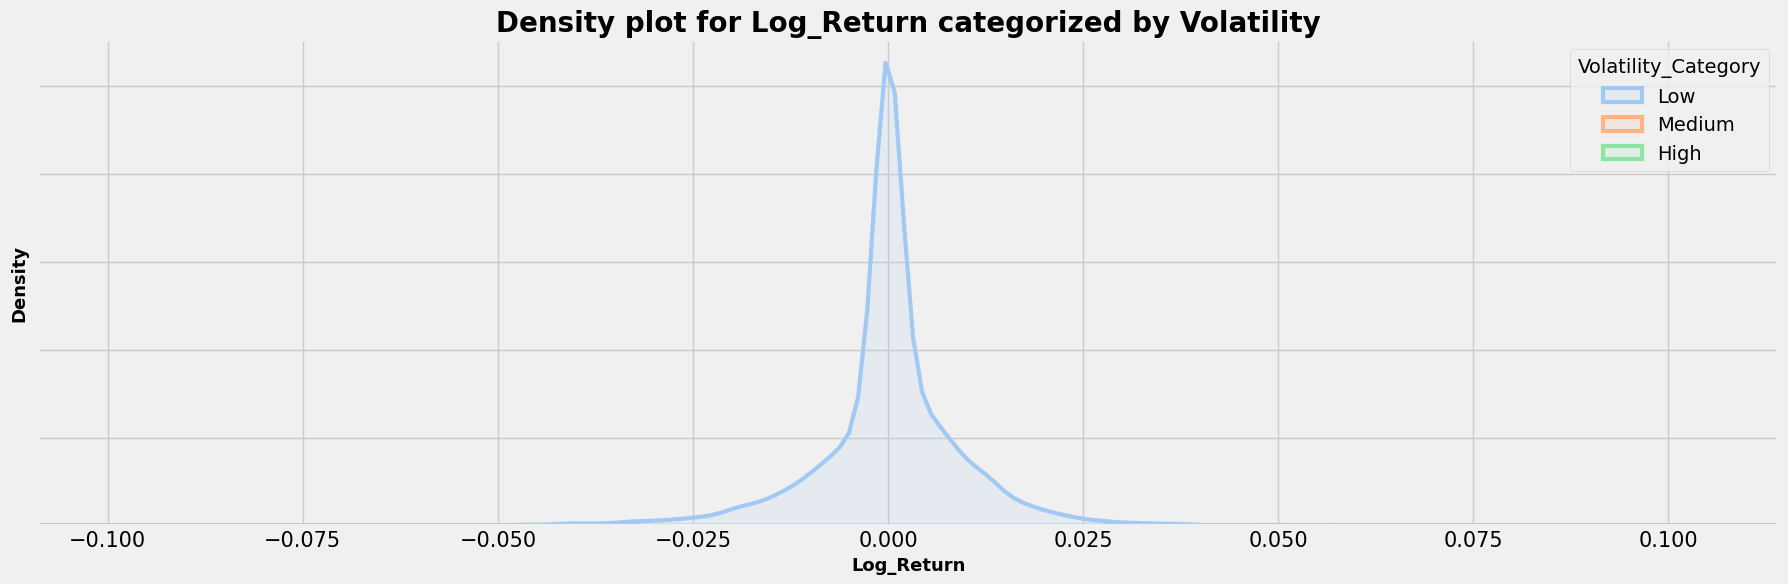

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the density plot for Log_Return, categorized by Volatility range
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Define volatility ranges for categorization
data['Volatility_Category'] = pd.cut(
    data['Volatility'], bins=[0, 0.1, 0.2, 0.3], labels=['Low', 'Medium', 'High']
)

# Plot
sns.kdeplot(
    data=data,
    x='Log_Return',
    hue='Volatility_Category',
    fill=True,
    alpha=0.15,
    ax=ax,
    linewidth=3,
    palette='pastel',
)

# Set axis labels and title
ax.set_xlabel('Log_Return', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(data['Log_Return'].min(), data['Log_Return'].max())
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])
ax.set_title(
    'Density plot for Log_Return categorized by Volatility', fontweight='bold', fontsize=20
)

plt.show()


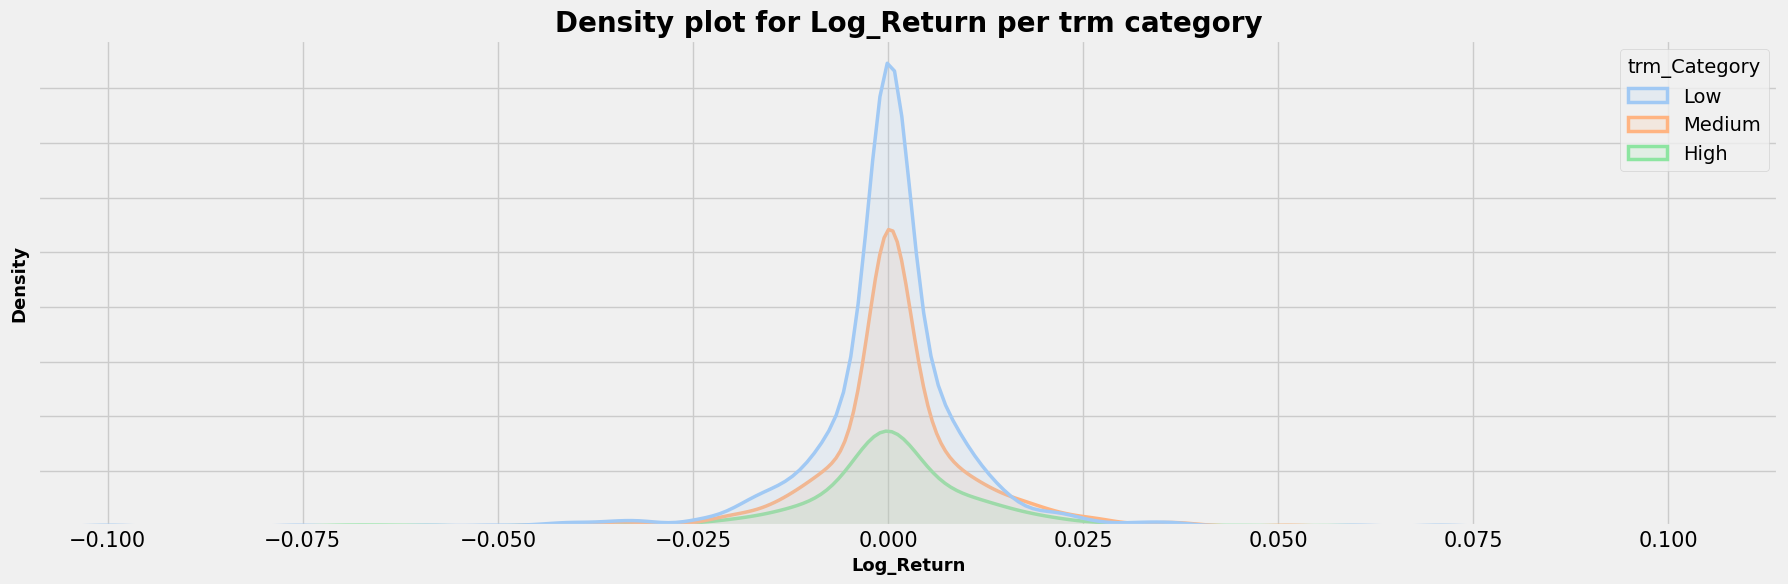

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the density plot for Log_Return, categorized by trm levels
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Define trm categories for visualization (e.g., grouping based on its values)
data['trm_Category'] = pd.cut(
    data['trm'], bins=[0, 1000, 1500, 2000], labels=['Low', 'Medium', 'High']
)

# Plot
sns.kdeplot(
    data=data,
    x='Log_Return',
    hue='trm_Category',
    fill=True,
    alpha=0.15,
    ax=ax,
    linewidth=2.5,
    palette='pastel',
)

# Set axis labels and title
ax.set_xlabel('Log_Return', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(data['Log_Return'].min(), data['Log_Return'].max())
ax.set_title(
    'Density plot for Log_Return per trm category', fontweight='bold', fontsize=20
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])

plt.show()


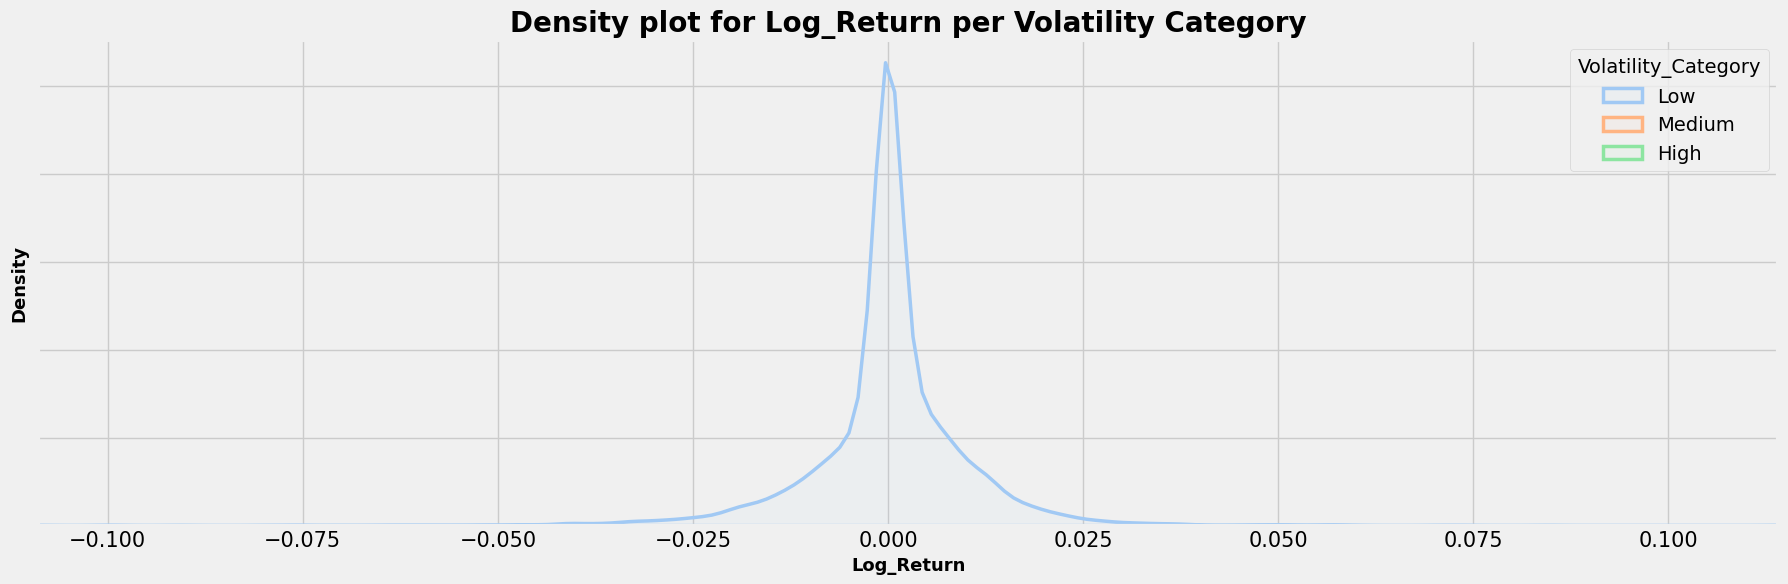

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the density plot for Log_Return, categorized by Volatility levels
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

# Define Volatility categories for visualization
data['Volatility_Category'] = pd.cut(
    data['Volatility'], bins=[0, 0.1, 0.2, 0.3], labels=['Low', 'Medium', 'High']
)

# Plot
sns.kdeplot(
    data=data,
    x='Log_Return',
    hue='Volatility_Category',
    fill=True,
    alpha=0.05,
    ax=ax,
    linewidth=2.5,
    palette='pastel',
)

# Set axis labels and title
ax.set_xlabel('Log_Return', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Density', color='black', fontweight='bold', fontsize=13)
ax.set_xlim(data['Log_Return'].min(), data['Log_Return'].max())
ax.set_title(
    'Density plot for Log_Return per Volatility Category', fontweight='bold', fontsize=20
)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_ticklabels([])

plt.show()


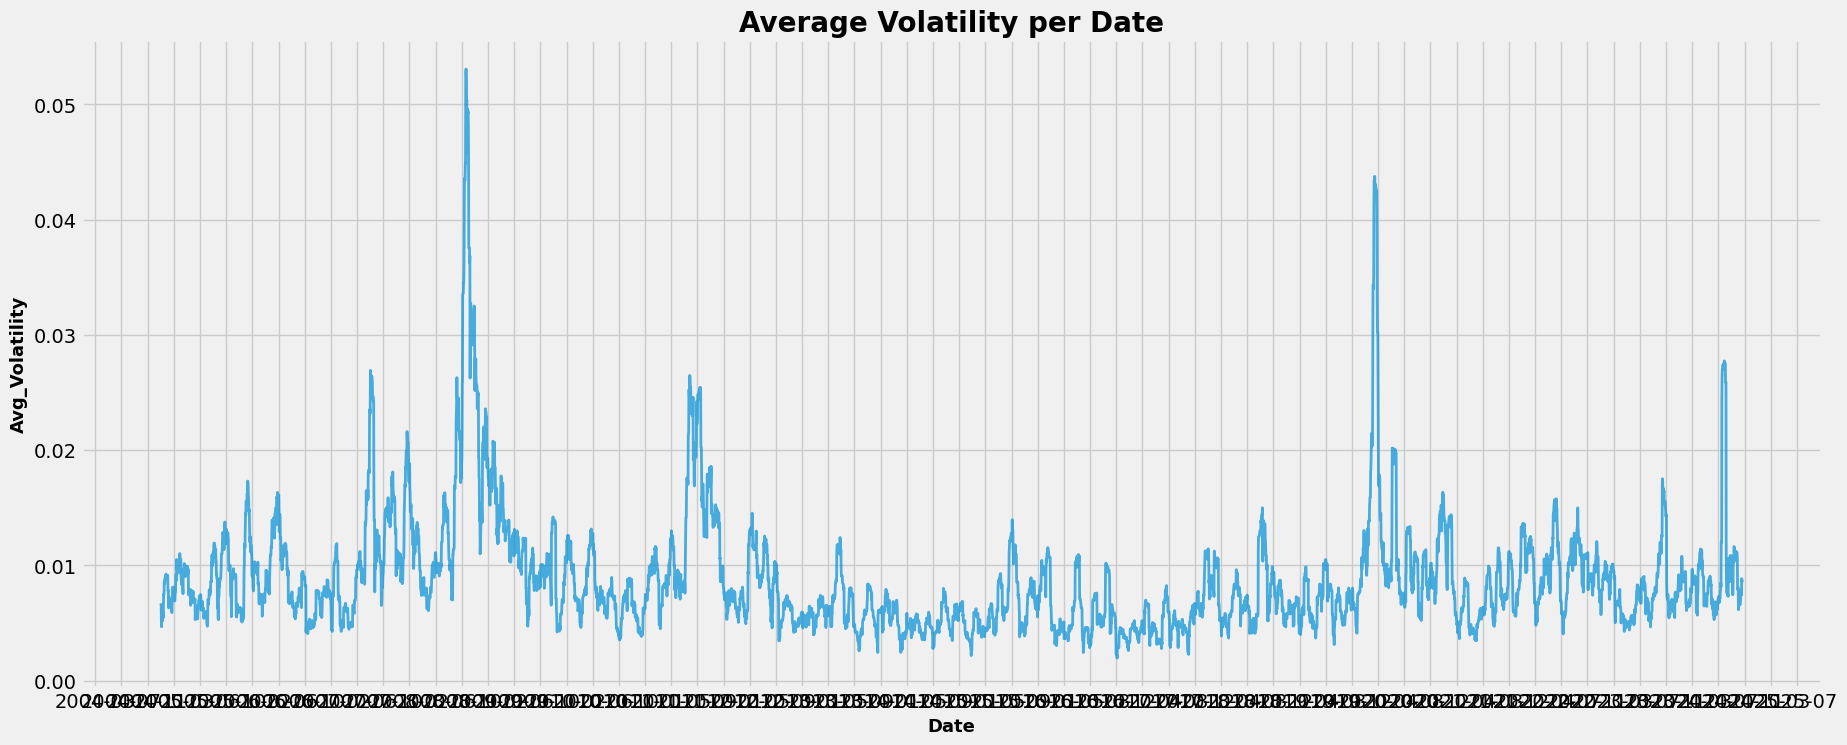

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Aggregate data: Calculate the average Volatility per Date
data_grouped = (
    data.groupby(['Date'])
    .agg({'Volatility': 'mean'})
    .rename(columns={'Volatility': 'Avg_Volatility'})
    .reset_index()
)

# Create the line plot
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(
    x='Date',
    y='Avg_Volatility',
    data=data_grouped,
    linewidth=2,
    alpha=0.7,
    ax=ax,
)

# Format the x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=120))

# Set axis labels and title
ax.set_xlabel('Date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Avg_Volatility', color='black', fontweight='bold', fontsize=13)
ax.set_title('Average Volatility per Date', fontweight='bold', fontsize=20)

plt.show()


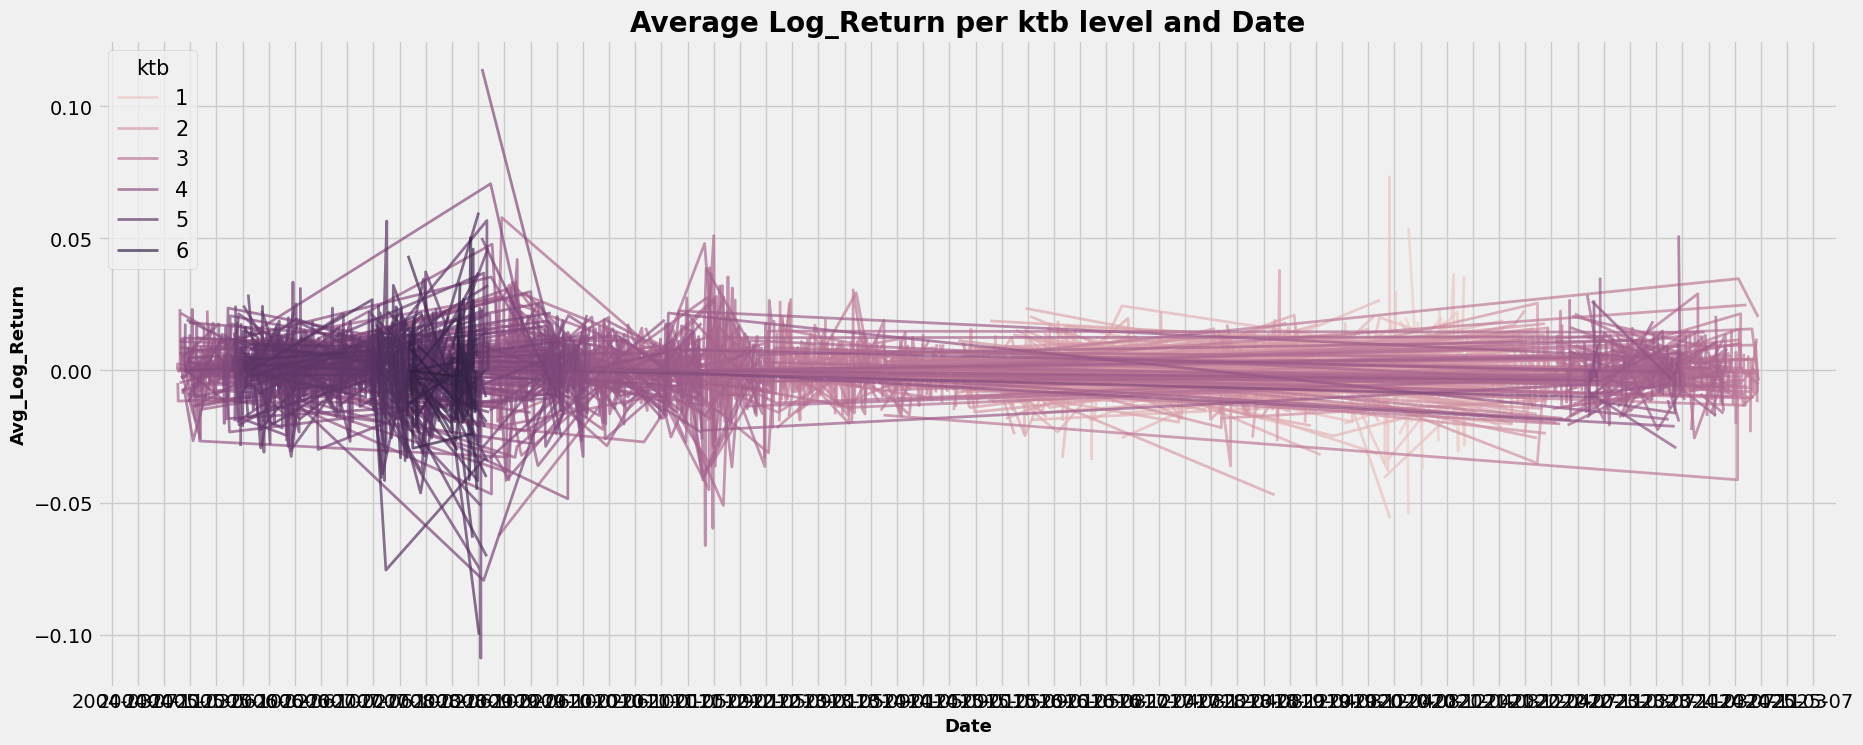

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Aggregate data: Calculate the average Log_Return per Date and ktb level
data_grouped = (
    data.groupby(['Date', 'ktb'])
    .agg({'Log_Return': 'mean'})
    .rename(columns={'Log_Return': 'Avg_Log_Return'})
    .reset_index()
    .sort_values('Date', ascending=True, ignore_index=True)
)

# Create the line plot
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(
    x='Date',
    y='Avg_Log_Return',
    hue='ktb',
    data=data_grouped,
    linewidth=2,
    alpha=0.7,
    ax=ax,
)

# Format the x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=120))

# Set axis labels and title
ax.set_xlabel('Date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Avg_Log_Return', color='black', fontweight='bold', fontsize=13)
ax.set_title('Average Log_Return per ktb level and Date', fontweight='bold', fontsize=20)

# Set legend
ax.legend(title='ktb', fontsize=15, loc='upper left', title_fontsize=15)

plt.show()


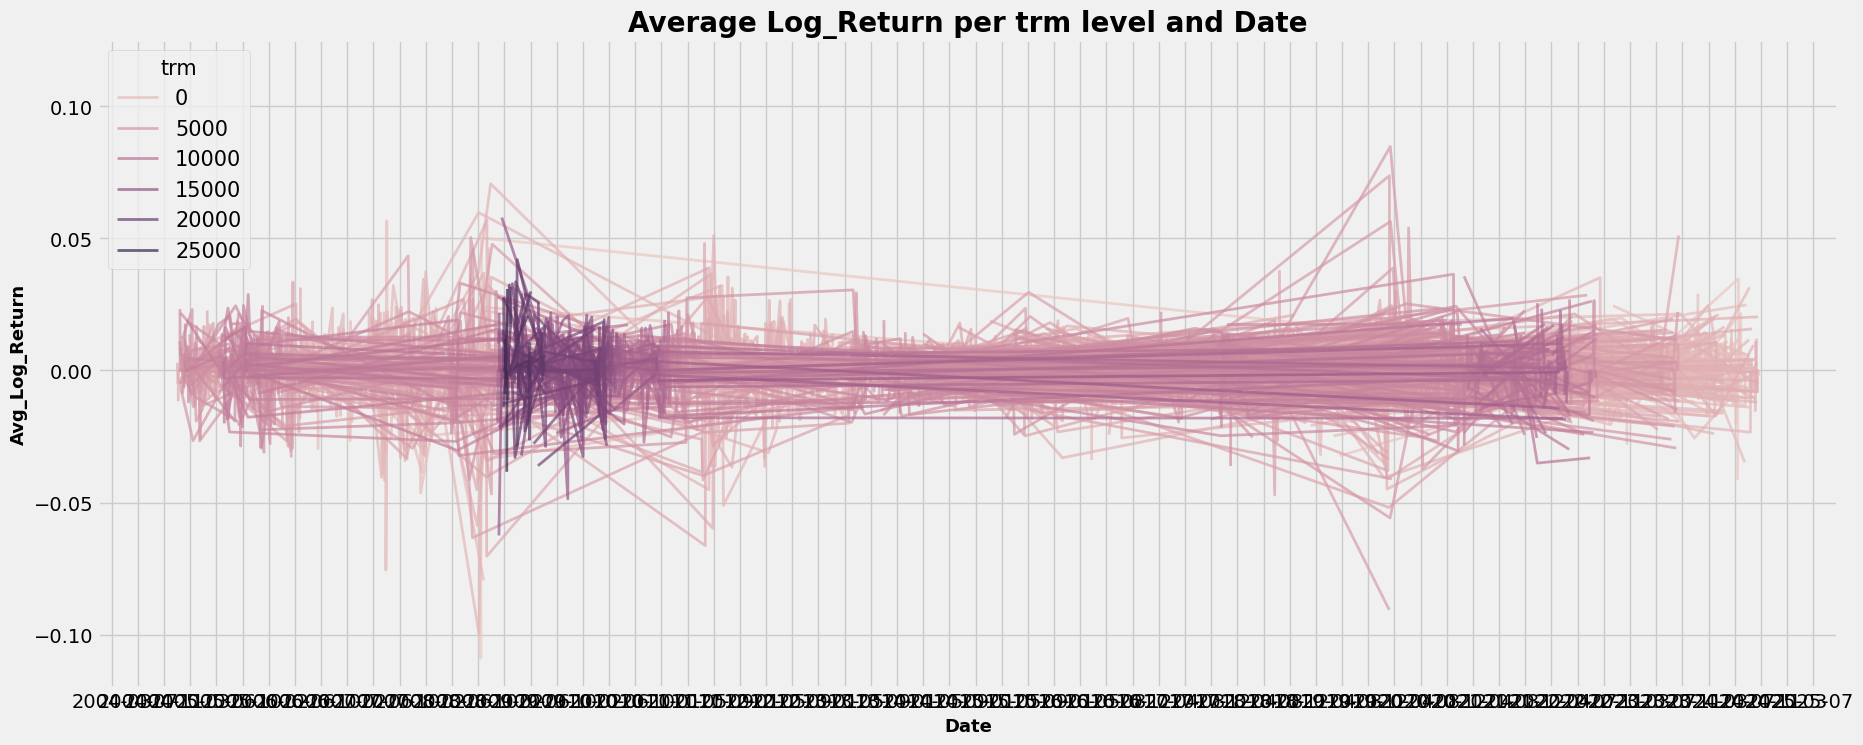

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Aggregate data: Calculate the average Log_Return per Date and trm level
data_grouped = (
    data.groupby(['Date', 'trm'])
    .agg({'Log_Return': 'mean'})
    .rename(columns={'Log_Return': 'Avg_Log_Return'})
    .reset_index()
    .sort_values('Date', ascending=True, ignore_index=True)
)

# Create the line plot
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(
    x='Date',
    y='Avg_Log_Return',
    hue='trm',
    data=data_grouped,
    linewidth=2,
    alpha=0.7,
    ax=ax,
)

# Format the x-axis for dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=120))

# Set axis labels and title
ax.set_xlabel('Date', color='black', fontweight='bold', fontsize=13)
ax.set_ylabel('Avg_Log_Return', color='black', fontweight='bold', fontsize=13)
ax.set_title('Average Log_Return per trm level and Date', fontweight='bold', fontsize=20)

# Set legend
ax.legend(title='trm', fontsize=15, loc='upper left', title_fontsize=15)

plt.show()


In [26]:
# Add a time_idx (a sequence of consecutive integers that goes from min to max Date)
data = data.merge(
    data[['Date']].drop_duplicates(ignore_index=True)
    .rename_axis('time_idx')
    .reset_index(),
    on=['Date']
)

# Display a sample to verify the time_idx column
data.head()


,row_id,Date,open,high,low,close,volume,return,Log_Return,Volatility,...,trm,spr,days_from_start,day_of_week,day_of_month,week_of_year,month,Volatility_Category,trm_Category,time_idx
0,1,2005-01-01,802.02,818.26,796.06,812.23,467875142,1.36,1.000000e-09,0.006695,...,1300,44000,1,6,1,52,1,Low,Medium,0
1,1,2005-01-02,802.02,818.26,796.06,812.23,467875142,1.36,1.000000e-09,0.006628,...,1300,44000,2,7,2,52,1,Low,Medium,1
2,1,2005-01-03,815.68,824.50,804.39,814.30,504220944,0.25,2.545297e-03,0.006476,...,1300,44000,3,1,3,1,1,Low,Medium,2
3,1,2005-01-04,812.53,823.47,801.12,810.44,646834180,-0.47,-4.751538e-03,0.004801,...,1300,44000,4,2,4,1,1,Low,Medium,3
4,1,2005-01-05,801.40,817.37,793.08,810.95,719967114,0.06,6.290900e-04,0.004657,...,1400,44000,5,3,5,1,1,Low,Medium,4


In [27]:
import pandas as pd
import numpy as np

# Convert 'Date' to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Add additional features
data["day_of_week"] = data['Date'].dt.dayofweek.astype(str).astype("category")  # Day of the week
data["week_of_year"] = data['Date'].dt.isocalendar().week.astype(str).astype("category")  # Week of the year
data["month"] = data['Date'].dt.month.astype(str).astype("category")  # Month

# Add log return (example of transformation)
data["log_return"] = np.log(data["return"] + 1e-8)

# Add rolling average for volatility
data["avg_volatility_7d"] = data["Volatility"].rolling(window=7).mean()
data["avg_volatility_30d"] = data["Volatility"].rolling(window=30).mean()

# Add rolling average for volume (if applicable)
data["avg_volume_7d"] = data["volume"].rolling(window=7).mean()
data["avg_volume_30d"] = data["volume"].rolling(window=30).mean()

# Fill NaN values created by rolling
data.fillna(method="bfill", inplace=True)

# Sample output
print(data.sample(5, random_state=30))


      row_id       Date     open     high      low    close      volume  \
6819       1 2023-09-03  2453.00  2517.11  2415.47  2469.70  1454698861   
2716       1 2012-06-09  1676.68  1692.48  1643.79  1658.33   915194455   
2744       1 2012-07-07  1700.33  1712.80  1664.41  1681.29   994829667   
1969       1 2010-05-24  1439.33  1479.51  1422.49  1457.12   706978528   
6797       1 2023-08-12  2485.97  2525.96  2444.98  2472.52  1789903791   

      return    Log_Return  Volatility  ...  week_of_year  month  \
6819    0.53  1.000000e-09    0.006559  ...            35      9   
2716   -0.75  1.000000e-09    0.011744  ...            23      6   
2744   -0.88  1.000000e-09    0.009117  ...            27      7   
1969    0.43  4.270939e-03    0.011777  ...            21      5   
6797   -0.25  1.000000e-09    0.008945  ...            32      8   

      Volatility_Category  trm_Category  time_idx log_return  \
6819                  Low          High      6819  -0.634878   
2716        

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-27-c0db001fdb07>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method="bfill", inplace=True)


In [28]:
# Ensure 'Date' column is datetime type
data['Date'] = pd.to_datetime(data['Date'])

# Split train and test data
split_ratio = 0.8  # Train/test split ratio
split_idx = int(len(data) * split_ratio)
train = data.iloc[:split_idx]
test = data.iloc[split_idx:]

# Define parameters
max_prediction_length = 24  # Predict the next 24 days
max_encoder_length = train['Date'].nunique()  # Number of unique dates in training data
training_cutoff = train["time_idx"].max() - max_prediction_length  # Training cutoff point

# Print key variables for confirmation
print(f"Train size: {len(train)}, Test size: {len(test)}")
print(f"Max prediction length: {max_prediction_length}")
print(f"Max encoder length: {max_encoder_length}")
print(f"Training cutoff (time_idx): {training_cutoff}")


Train size: 5801, Test size: 1451
Max prediction length: 24
Max encoder length: 5801
Training cutoff (time_idx): 5776


In [29]:
print(f"Train time_idx range: {train['time_idx'].min()} to {train['time_idx'].max()}")
print(f"Train size: {len(train)}, Max prediction length: {max_prediction_length}")


Train time_idx range: 0 to 5800
Train size: 5801, Max prediction length: 24


In [30]:
# Adjust encoder lengths if necessary
min_encoder_length = min(max_prediction_length, len(train) - max_prediction_length)
max_encoder_length = min(max_encoder_length, len(train) - max_prediction_length)

print(f"Adjusted encoder lengths: Min={min_encoder_length}, Max={max_encoder_length}")


Adjusted encoder lengths: Min=24, Max=5777


In [31]:
# Ensure max_prediction_length is not larger than the available data
max_prediction_length = min(max_prediction_length, len(train) - min_encoder_length)
print(f"Adjusted max prediction length: {max_prediction_length}")


Adjusted max prediction length: 24


In [32]:
# Check the range of time_idx and adjust parameters accordingly
print(f"Train time_idx range: {train['time_idx'].min()} to {train['time_idx'].max()}")
print(f"Train size: {len(train)}, Test size: {len(test)}")

# Adjust parameters based on available data
max_prediction_length = min(12, len(train) // 3)  # Reduce prediction length if necessary
min_encoder_length = min(max_prediction_length, 12)  # Shorter encoder length
max_encoder_length = len(train) - max_prediction_length

training_cutoff = max(
    train["time_idx"].min() + min_encoder_length + max_prediction_length,
    train["time_idx"].max() - max_prediction_length
)
print(f"Adjusted Min encoder length: {min_encoder_length}, Max encoder length: {max_encoder_length}")
print(f"Adjusted Training cutoff: {training_cutoff}")

# Add a single group ID column for single time series
train["id"] = 0  # Single group ID

# Create a TimeSeriesDataSet
training = TimeSeriesDataSet(
    train[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Volatility",
    group_ids=["id"],  # Grouping by the single ID column
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_categoricals=["day_of_week", "week_of_year", "month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "open", "high", "low", "close", "volume", "return", "Log_Return",
        "avg_volatility_7d", "avg_volatility_30d", "avg_volume_7d", "avg_volume_30d"
    ],
    target_normalizer=GroupNormalizer(groups=["id"], transformation="softplus"),  # Use group normalization
    categorical_encoders={
        "day_of_week": NaNLabelEncoder(add_nan=True),
        "week_of_year": NaNLabelEncoder(add_nan=True),
        "month": NaNLabelEncoder(add_nan=True),
    },
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# Validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training, train, predict=True, stop_randomization=True
)

# Create DataLoaders
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)



<ipython-input-32-18418df32dc6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["id"] = 0  # Single group ID


Train time_idx range: 0 to 5800
Train size: 5801, Test size: 1451
Adjusted Min encoder length: 12, Max encoder length: 5789
Adjusted Training cutoff: 5788


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [33]:
# Data loading
data = pd.read_csv('MK2000_with_macro_and_volatility.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Ensure Date column is in datetime format

In [34]:
# Ensure 'Date' is in datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Create 'time_idx' as the number of days from the start of the dataset
data["time_idx"] = (data["Date"] - data["Date"].min()).dt.days

# Split data into training and testing sets
train = data[data["Date"] < "2021-01-01"]  # Training data before 2021
test = data[data["Date"] >= "2021-01-01"]  # Testing data starts in 2021

# Calculate the maximum prediction and encoder lengths
max_prediction_length = 24  # Predict the entire year of 2021
max_encoder_length = train["Date"].nunique()  # Number of unique dates in the training data

# Compute the training cutoff for validation
training_cutoff = train["time_idx"].max() - max_prediction_length  # Validate on the last year of training data

# Display the shapes and calculated values
train.shape, test.shape, max_prediction_length, max_encoder_length, training_cutoff


((5844, 20), (1408, 20), 24, 5844, 5819)

In [35]:
# Create a full range of time indices
full_time_range = pd.DataFrame({"time_idx": range(data["time_idx"].min(), data["time_idx"].max() + 1)})

# Merge with the original data to fill missing time steps
data = full_time_range.merge(data, on="time_idx", how="left")

# Fill missing values as needed (e.g., forward fill for certain columns)
data = data.fillna(method="ffill")  # Forward fill
data = data.fillna(method="bfill")  # Backward fill (if necessary)


<ipython-input-35-2b1a681ec778>:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill")  # Forward fill
<ipython-input-35-2b1a681ec778>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="bfill")  # Backward fill (if necessary)


In [36]:
# Convert relevant columns to string or categorical types
categorical_columns = ["day_of_week", "week_of_year", "month"]
for col in categorical_columns:
    data[col] = data[col].astype(str)

# Ensure a unique group identifier exists
data["unique_group"] = 0  # Use 0 for a single group

# Ensure 'time_idx' is an integer
data["time_idx"] = data["time_idx"].astype(int)

# Check time_idx continuity and fill missing steps if allow_missing_timesteps is True
if data["time_idx"].is_unique and data["time_idx"].diff().min() > 1:
    print("Warning: Missing time steps detected in time_idx.")

# Adjust the TimeSeriesDataSet
training = TimeSeriesDataSet(
    data[data["time_idx"] <= training_cutoff],
    time_idx="time_idx",
    target="Volatility",
    group_ids=["unique_group"],  # Single group identifier
    min_encoder_length=max(1, max_encoder_length // 2),  # Ensure non-zero min encoder length
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    time_varying_known_categoricals=["day_of_week", "week_of_year", "month"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "open", "high", "low", "close", "volume", "return", "Log_Return",
        "exc", "ktb", "trm", "spr", "Volatility"
    ],
    target_normalizer=GroupNormalizer(groups=["unique_group"], transformation="softplus"),
    categorical_encoders={
        "day_of_week": NaNLabelEncoder(add_nan=True),
        "week_of_year": NaNLabelEncoder(add_nan=True),
        "month": NaNLabelEncoder(add_nan=True),
    },
    lags={"Volatility": [7, 30, 365]},  # Ensure lag values fit data length
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # Allows missing time steps
)

# Create validation set
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# Debugging information
print(f"Training set size: {len(train_dataloader.dataset)}")
print(f"Validation set size: {len(val_dataloader.dataset)}")



Training set size: 5019
Validation set size: 1


In [37]:
# Ensure validation dataloader is created
val_dataloader = validation.to_dataloader(train=False, batch_size=128 * 10, num_workers=0)

# Get actual values and move them to the same device as the model (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actuals = torch.cat([y.to(device) for x, (y, weight) in iter(val_dataloader)])

# Baseline model predictions, ensure they're on the same device
baseline_model = Baseline().to(device)
baseline_predictions = baseline_model.predict(val_dataloader).to(device)

# Calculate mean absolute error for baseline model
mae = (actuals - baseline_predictions).abs().mean().item()

# Calculate SMAPE
smape_metric = SMAPE()
smape_value = smape_metric(actuals, baseline_predictions)

# Output results
print(f"Baseline MAE: {mae}")
print(f"Baseline SMAPE: {smape_value}")


<ipython-input-37-7dbb29e1b9d4>:9: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_model = Baseline().to(device)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribut

Baseline MAE: 0.0029282334726303816
Baseline SMAPE: 0.3264537751674652


In [38]:
# Calculate the median loss using SMAPE
smape_metric = SMAPE()

# Calculate SMAPE loss for each sample
loss_per_sample = smape_metric.loss(actuals, baseline_predictions)

# Calculate the median loss
median_loss = loss_per_sample.mean(axis=1).median().item()

# Output the median loss
print(f"Median loss for naive prediction on validation: {median_loss}")


Median loss for naive prediction on validation: 0.3264538049697876


In [39]:
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.03
OPTUNA = False

In [1]:
!pip install pytorch-lightning==2.0.0


In [40]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
import pytorch_lightning as pl
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

# 상수 정의
MAX_EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 5

# EarlyStopping, LearningRateMonitor, Logger 설정
early_stop_callback = EarlyStopping(
    monitor="val_loss",  # 검증 손실 기준으로 조기 종료
    min_delta=1e-2,
    patience=PATIENCE,
    verbose=False,
    mode="min",
)
lr_logger = LearningRateMonitor()  # 학습률 로깅
logger = TensorBoardLogger("lightning_logs")  # 텐서보드에 로그 기록

# TemporalFusionTransformer를 LightningModule로 래핑
class TFTLightningWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        x, y = self._move_to_device(batch)
        output = self.model.training_step((x, y), batch_idx)
        return output

    def validation_step(self, batch, batch_idx):
        x, y = self._move_to_device(batch)
        output = self.model.validation_step((x, y), batch_idx)
        return output

    def configure_optimizers(self):
        return self.model.configure_optimizers()

    def _move_to_device(self, batch):
        device = self.device  # 현재 모델이 위치한 디바이스
        x, y = batch

        # x를 GPU로 이동
        x = {key: value.to(device) for key, value in x.items()}

        # y를 GPU로 이동 (None 값 처리)
        if isinstance(y, tuple):
            y = tuple(v.to(device) if v is not None else None for v in y)
        else:
            y = y.to(device) if y is not None else None

        return x, y


# TemporalFusionTransformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,
    loss=SMAPE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# 모델을 명시적으로 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tft = tft.to(device)

# LightningModule로 래핑
tft_wrapped = TFTLightningWrapper(tft)

# Trainer 생성
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    enable_model_summary=True,
    gradient_clip_val=0.25,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Trainer에 모델 연결 테스트
assert isinstance(tft_wrapped, pl.LightningModule), "tft_wrapped는 LightningModule이어야 합니다."

# 학습 시작
trainer.fit(
    tft_wrapped,  # 래핑된 모델 전달
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

# Trainer가 모델을 감지했는지 확인
assert trainer.lightning_module is not None, "Trainer에 LightningModule이 연결되지 않았습니다."


/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IP

Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: TemporalFusionTransformer is not attached to a `Trainer`.

In [48]:
pip install -U pytorch-forecasting


In [50]:
pip install -U pytorch-lightning


In [51]:
from pytorch_lightning import LightningModule
print(isinstance(tft, LightningModule))  # True여야 합니다.


False


In [46]:
from pytorch_forecasting.models.temporal_fusion_transformer import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=True)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="tft-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min",
)

# Trainer
trainer = Trainer(
    max_epochs=30,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else None,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback, checkpoint_callback],
    log_every_n_steps=10,
)

# TemporalFusionTransformer Model
tft = TemporalFusionTransformer.from_dataset(
    training,  # Ensure 'training' is a valid TimeSeriesDataSet
    learning_rate=1e-3,
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=64,
    output_size=7,  # Number of quantiles
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)

# Check model initialization
print(tft)

# Fit the model
trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': 'Volatility', 'group_ids': ['unique_group'], 'weight': None, 'max_encoder_length': 5844, 'min_encoder_length': 2922, 'min_prediction_idx': 0, 'min_prediction_length': 24, 'max_prediction_length': 24, 'static_categoricals': [], 'static_reals': None, 'time_varying_known_categoricals': ['day_of_week', 'week_of_year', 'month'], 'time_varying_known_reals': ['time_idx'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': ['open', 'high', 'low', 'close', 'volume', 'return', 'Log_Return', 'exc', 'ktb', 'trm', 'spr', 'Volatility'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': {'Volatility': [7, 30, 365]}, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True, 'targ

TypeError: `model` must be a `LightningModule` or `torch._dynamo.OptimizedModule`, got `TemporalFusionTransformer`

In [47]:
from pytorch_lightning import LightningModule
print(isinstance(tft, LightningModule))  # 결과가 True여야 합니다.


False


In [ ]:
assert trainer.lightning_module is not None, "Trainer에 LightningModule이 연결되지 않았습니다."


AssertionError: Trainer에 LightningModule이 연결되지 않았습니다.

In [ ]:
# 모델과 데이터가 동일한 장치에 있는지 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for batch in train_dataloader:
    x, y = batch
    for key, value in x.items():
        assert value.device == device, f"Tensor {key} is not on the correct device"
    if y is not None:
        assert y.device == device, "Target is not on the correct device"
    break


In [ ]:
for batch in train_dataloader:
    x, y = batch
    for key, value in x.items():
        assert value.device == device, f"Tensor {key} is not on the correct device"
    if y is not None:
        assert y.device == device, "Target is not on the correct device"
    break  # 첫 번째 배치만 확인


AssertionError: Tensor encoder_cat is not on the correct device

In [ ]:
def move_batch_to_device(batch, device):
    x, y = batch

    # x 이동
    x = {key: value.to(device) for key, value in x.items()}

    # y 이동 (None 처리 포함)
    if isinstance(y, tuple):
        y = tuple(v.to(device) if v is not None else None for v in y)
    else:
        y = y.to(device) if y is not None else None

    return x, y

# train_dataloader와 val_dataloader를 수정
class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield move_batch_to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)


In [ ]:

# 학습
trainer.fit(
    tft_wrapped,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode 
------------------------------------------------------------
0 | model | TemporalFusionTransformer | 36.8 K | train
------------------------------------------------------------
36.8 K    Trainable params
0         Non-trainable params
36.8 K    Total params
0.147     Total estimated model params size (MB)
541       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: TemporalFusionTransformer is not attached to a `Trainer`.

In [ ]:
!pip list | grep forecasting
!pip list | grep lightning


pytorch-forecasting                1.2.0
lightning                          2.4.0
lightning-utilities                0.11.9
pytorch-lightning                  2.4.0


\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
새로운 버전
\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [ ]:
data = pd.read_csv('MK2000_with_macro_and_volatility.csv')

In [ ]:
# 2. 날짜 형식 변환 및 정렬
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

In [ ]:
# 3. 필요한 형식으로 변환 및 피처 추가
# 숫자 데이터로 변환
# Check if the column is of type object (string) before applying str methods
for col in ['open', 'high', 'low', 'close', 'volume', 'return', 'Log_Return', 'exc', 'ktb', 'trm', 'spr', 'days_from_start', 'day_of_week', 'day_of_month', 'week_of_year', 'month']:
    if data[col].dtype == object:
        data[col] = data[col].str.replace(',', '').astype(float)
    else:
        print(f"Column '{col}' is not of string type. Skipping str.replace.")


Column 'open' is not of string type. Skipping str.replace.
Column 'high' is not of string type. Skipping str.replace.
Column 'low' is not of string type. Skipping str.replace.
Column 'close' is not of string type. Skipping str.replace.
Column 'volume' is not of string type. Skipping str.replace.
Column 'return' is not of string type. Skipping str.replace.
Column 'Log_Return' is not of string type. Skipping str.replace.
Column 'exc' is not of string type. Skipping str.replace.
Column 'ktb' is not of string type. Skipping str.replace.
Column 'trm' is not of string type. Skipping str.replace.
Column 'spr' is not of string type. Skipping str.replace.
Column 'days_from_start' is not of string type. Skipping str.replace.
Column 'day_of_week' is not of string type. Skipping str.replace.
Column 'day_of_month' is not of string type. Skipping str.replace.
Column 'week_of_year' is not of string type. Skipping str.replace.
Column 'month' is not of string type. Skipping str.replace.


In [ ]:
# 4. TFT 모델 입력 형식으로 설정
# 필요한 컬럼 지정
data['time_idx'] = (data['Date'] - data['Date'].min()).dt.days  # 날짜를 time_idx로 변환
data['group'] = 0  # 단일 시계열이므로 그룹을 0으로 설정

In [ ]:
# 변환해야 할 컬럼 리스트
categorical_columns = ["day_of_week", "day_of_month", "week_of_year", "month"]

# 각 컬럼을 문자열로 변환
for col in categorical_columns:
    data[col] = data[col].astype(str)


In [ ]:
data = data.set_index("Date").asfreq("D").reset_index()  # 날짜 기준으로 결측치 생성


In [ ]:
# 데이터 정렬 (Date 기준)
data = data.sort_values(by="Date").reset_index(drop=True)

# 연속적인 time_idx 생성
data["time_idx"] = range(len(data))


In [ ]:
print(data["time_idx"].dtype)  # 출력: int64 또는 int32


int64


In [ ]:
categorical_encoders={
    "day_of_week": NaNLabelEncoder(add_nan=True),
    "day_of_month": NaNLabelEncoder(add_nan=True),
    "week_of_year": NaNLabelEncoder(add_nan=True),
    "month": NaNLabelEncoder(add_nan=True),
}


In [ ]:
categorical_columns = ["day_of_week", "day_of_month", "week_of_year", "month"]

for col in categorical_columns:
    # NaN 값을 "missing"으로 대체
    data[col] = data[col].fillna("missing").astype(str)


In [ ]:
# define dataset
max_encoder_length = 36
max_prediction_length = 24
# Define training_cutoff here with a specific date
#training_cutoff = "2023-01-01"  # Example: Set cutoff to January 1, 2023
# or use a percentage of your data
training_cutoff = data['Date'].quantile(0.8) # Example: Use the 80th percentile as cutoff
# Convert training_cutoff to datetime object
training_cutoff = pd.to_datetime(training_cutoff)

# Access the 'Date' column and compare it to training_cutoff
training = TimeSeriesDataSet(
    data[lambda x: pd.to_datetime(x['Date']) < training_cutoff], # Access the 'Date' column using x['Date']
    time_idx= "time_idx", # Replace ... with "time_idx"
    target= "Volatility", # Replace ... with the name of your target column, e.g., "Close"
    # weight="weight",
    group_ids=["group"], # Replace ... with ["group"]
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[], # Replace ... with your static categorical features, if any
    static_reals=[], # Replace ... with your static real features, if any
    # in these codes, set the encoder and decoder(known) variables.
    time_varying_known_categoricals=['day_of_week', 'day_of_month', 'week_of_year', 'month'], # Replace ... with your time-varying known categorical features, if any
    time_varying_known_reals=["time_idx", 'volume', 'days_from_start'], # Replace ... with your time-varying known real features, if any
    time_varying_unknown_categoricals=[], # Replace ... with your time-varying unknown categorical features, if any
    time_varying_unknown_reals=['open', 'high', 'low', 'close', 'return', 'Log_Return', 'Volatility'], # Replace ... with your time-varying unknown real features, if any
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, train, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

NameError: name 'train' is not defined

In [ ]:
# 데이터셋 정의
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet

# 설정
max_encoder_length = 36
max_prediction_length = 24

# training_cutoff 설정 (데이터의 80%를 훈련용으로 사용)
training_cutoff = data['Date'].quantile(0.8)  # 80% 시점
training_cutoff = pd.to_datetime(training_cutoff)  # datetime 형식으로 변환

# TimeSeriesDataSet 생성
training = TimeSeriesDataSet(
    data[lambda x: pd.to_datetime(x['Date']) < training_cutoff],  # training_cutoff 이전 데이터만 포함
    time_idx="time_idx",  # time index 열
    target="Volatility",  # 예측 대상 열
    group_ids=["group"],  # 그룹화 ID
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # 정적 범주형 변수
    static_reals=[],  # 정적 실수 변수
    time_varying_known_categoricals=["day_of_week", "day_of_month", "week_of_year", "month"],  # 시간에 따라 변하는 범주형 변수
    time_varying_known_reals=["time_idx", "volume", "days_from_start"],  # 시간에 따라 변하는 알려진 실수 변수
    time_varying_unknown_categoricals=[],  # 시간에 따라 변하는 알려지지 않은 범주형 변수
    time_varying_unknown_reals=["open", "high", "low", "close", "return", "Log_Return", "Volatility"],  # 시간에 따라 변하는 알려지지 않은 실수 변수
)

# validation 데이터셋 생성
validation = TimeSeriesDataSet.from_dataset(
    training,
    data[lambda x: pd.to_datetime(x['Date']) >= training_cutoff],  # validation_cutoff 이후 데이터
    predict=True,
    stop_randomization=True,
)

# DataLoader 생성
batch_size = 128  # GPU 메모리에 맞게 설정
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

# 확인
print(f"Training DataLoader: {len(train_dataloader)} batches")
print(f"Validation DataLoader: {len(val_dataloader)} batches")


Training DataLoader: 44 batches
Validation DataLoader: 1 batches


In [ ]:
import torch
from pytorch_forecasting import Baseline
from pytorch_forecasting.metrics import SMAPE

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Validation Dataloader로 실제 값 가져오기
actuals = torch.cat([y.to(device) for x, (y, weight) in iter(val_dataloader)])  # GPU로 이동

# Baseline 모델 생성
baseline_model = Baseline()  # Baseline 모델 초기화

# Baseline 모델 예측값 생성
baseline_predictions = baseline_model.predict(val_dataloader).to(device)  # GPU로 이동

# MAE 계산
mae = (actuals - baseline_predictions).abs().mean().item()
print(f"Baseline MAE: {mae}")

# SMAPE 계산
smape_metric = SMAPE()
smape_value = smape_metric(actuals, baseline_predictions)
print(f"Baseline SMAPE: {smape_value}")


<ipython-input-16-bef508f599c1>:12: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  baseline_model = Baseline()  # Baseline 모델 초기화
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208:

Baseline MAE: 0.0029282334726303816
Baseline SMAPE: 0.3264537751674652


In [ ]:
print(f"Median loss for naive prediction on validation: {smape_metric.loss(actuals, baseline_predictions).mean(axis = 1).median().item()}")

Median loss for naive prediction on validation: 0.3264538049697876


In [ ]:
PATIENCE = 30
MAX_EPOCHS = 120
LEARNING_RATE = 0.03
OPTUNA = False

In [ ]:
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=1e-2, patience=PATIENCE, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard



# Trainer 설정
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",  # GPU가 사용 가능한 경우 GPU로 설정
    devices=1 if torch.cuda.is_available() else None,  # GPU 장치 수 설정 (여기서는 1개 사용)
    enable_model_summary=True,
    gradient_clip_val=0.25,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)



tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=LEARNING_RATE,
    lstm_layers=2,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.2,
    hidden_continuous_size=8,
    output_size=1,  # 7 quantiles by default
    loss=SMAPE(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4
)

#tft.to(DEVICE)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Number of parameters in network: 30.0k


In [ ]:
def move_batch_to_device(batch, device):
    """
    Batch 데이터를 GPU로 이동
    """
    x, y = batch

    # x를 GPU로 이동
    x = {key: value.to(device) for key, value in x.items()}

    # y가 튜플인지 확인하고 각 요소를 GPU로 이동
    if isinstance(y, tuple):
        y = tuple(v.to(device) if v is not None else None for v in y)
    else:
        y = y.to(device)

    return x, y

class DeviceDataLoader:
    """
    DataLoader의 배치를 지정된 디바이스로 이동시키는 래퍼 클래스
    """
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield move_batch_to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)


In [ ]:
# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU로 이동
tft.to(device)

# DataLoader를 GPU로 이동
def move_batch_to_device(batch, device):
    x, y = batch
    x = {key: value.to(device) for key, value in x.items()}  # x를 GPU로 이동
    y = y.to(device) if not isinstance(y, tuple) else tuple(v.to(device) if v is not None else None for v in y)  # y를 GPU로 이동
    return x, y

# DataLoader 래핑
class DeviceDataLoader:
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device

    def __iter__(self):
        for batch in self.dataloader:
            yield move_batch_to_device(batch, self.device)

    def __len__(self):
        return len(self.dataloader)

# train_dataloader와 val_dataloader를 GPU로 이동
train_dataloader = DeviceDataLoader(train_dataloader, device)
val_dataloader = DeviceDataLoader(val_dataloader, device)


In [ ]:
class TFTLightningWrapper(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        return self.model(*args, **kwargs)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.model.training_step((x, y), batch_idx)
        return output

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.model.validation_step((x, y), batch_idx)
        return output

    def configure_optimizers(self):
        return self.model.configure_optimizers()


In [ ]:
# 모델 래핑
tft_wrapped = TFTLightningWrapper(tft)

# Trainer 생성
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.25,
)

# 디버깅: Trainer와 모델 연결 확인
assert trainer.lightning_module is None, "Trainer에 LightningModule이 연결되지 않았습니다."

# 학습
trainer.fit(
    tft_wrapped,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                      | Params | Mode
-----------------------------------------------------------
0 | model | TemporalFusionTransformer | 30.0 K | eval
-----------------------------------------------------------
30.0 K    Trainable params
0         Non-trainable params
30.0 K    Total params
0.120     Total estimated model params size (MB)
0         Modules in train mode
372       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

RuntimeError: TemporalFusionTransformer is not attached to a `Trainer`.